## Project: Analyze A/B Test Results

**_By Sebastian Sbirna_**

An e-commerce company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. Through this notebook, the company's decision will be tested to let the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists to test changes on a web page by running an experiment where a control group sees the old version, while the experiment group sees the new version. A metric (_in our case, the "converted" rate_) is then chosen to measure the level of engagement from users in each group. These results are then used to judge whether one version is more effective than the other.

This project will analyze the statistical likelihood of increasing conversion rates due to a newer version of the landing page, and will consolidate and validate its results by demonstrating the same statistical effects using three statistical methods: probability, hypothesis testing, and, lastly, logistic regression. 

<a id='probability'></a>
#### Part I - Probability

To get started, we're importing our necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import random
random.seed(42)

First, we are loading the dataset from our .csv file, and inspecting its format:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Next, it's a good idea to understand more about its contents before moving to data cleaning and exploration:

First, we check for the shape of the DataFrame (showing the total nr. of elements) and the Python-inserted variable types:

In [3]:
df.shape

(294478, 5)

In [4]:
df.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

Then we look into the number of unique values for each column set, so as to detect possible inconsistencies or duplicates:

In [5]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

From the number of unique values, we can identify that there are there are as many unique timestamps as there are entries, however the number of users is less than the number of entries (even though the data collection process was set-up in a way that this should not have happened).

We want to find out the number of inconsistencies, which are likely due to mismatching between the group the user was randomly placed in and the version of the landing page received.

In [6]:
len(df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')]) + \
len(df[(df['group'] == 'control') & (df['landing_page'] != 'old_page')])

3893

Indeed, there are such inconsistencies, which we will eliminate straight away.

We will check to see if any of the rows have missing values:

In [7]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

There are no missing or NaN values, meaning we can proceed into eliminating the mismatched entries.

For the rows where `treatment` is not aligned with `new_page` or `control` is not aligned with `old_page`, we cannot be sure if these users truly received the new or old page. Since we should only use the entries that we can feel confident in the accuracy of the data, the mismatched rows will be removed (_dropped_)

We will create a new dataset that meets these specifications:

In [8]:
df2 = df.drop(df.query("group == 'control' and landing_page == 'new_page'").index)\
        .drop(df.query("group == 'treatment' and landing_page == 'old_page'").index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
len(df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False])

0

Now we will check again for unique values, to see if the number of unique users align with the number of total entries of the dataset (_as each user should have only been recorded once, belonging into either the_ `control` _or the_ `treatment` _group_)

In [10]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

There is one `user_id` which is still repeated in `df2`. We will investigate it:

In [11]:
print(df2.user_id.value_counts().index[0])

773192


We will check the entries for this user, in order to understand why it is a duplicate.

In [12]:
df2[df2.user_id == df2.user_id.value_counts().index[0]]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


It appears to have been some sort of error within the data collection process, as these entries are neither mismatched in group or landing_page nor in conversion status.

In this case, by analysing both entries, it is safe to say that the only difference between them is the timestamp of collection. We will therefore remove one of the duplicate rows, at random.

In [13]:
df2 = df2.drop_duplicates('user_id')

Now that we have cleaned our dataset, we can start the statistical analysis of the impact of the two page formats upon the conversion rate.

We will compute some essential probabilities which will help us understand the task better, starting with _the probability of an individual converting regardless of the page they receive_.

In [14]:
df2.converted.mean()

0.11959708724499628

Next, given that an individual was in the `control` group, what is the probability they converted?

In [15]:
p_obs_control = df2.query("group == 'control'").converted.mean()

Likewise, given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
p_obs_treatment = df2.query("group == 'treatment'").converted.mean()

Now, we can compute the observed difference between conversion probabilites from our dataset:

In [45]:
observed_value = p_obs_treatment - p_obs_control
observed_value

-0.0015782389853555567

Since this A/B test is an experimental test, we would like to uniformly distribute the users in a _**random**_ manner into the `control` and the `treatment` group respectively. 

We will check for the distribution of the `landing_page`, just to check whether it comes close to ~0.5 (50%).

In [18]:
len(df2.query("landing_page == 'new_page'")) / len(df2)

0.5000619442226688

**_So far, based on the computed probability of conversion, we would be inclined to say that there is not enough evidence to suggest that the new webpage design increases in any way conversion rate. And, looking at the magnitude of the difference, it seems clear to say that this result is not practically significant either._** 

**_However, even though we would be inclined to consider this result as significant due to the large sample size of the test, it needs to be noticed that our previous calculations were only describing the observed probabilities, however we have mentioned nothing about the statistical significance of such results._**

<a id='ab_test'></a>
### Part II - A/B Test

In order to provide reasoning behind our choices, we will want to verify the results from the observed values in a statistical manner, which can determine with enough confidence whether or not the new webpage design should be implemented.

We will now perform a statistical hypothesis test upon the conversion rate of the two page versions.

We assume that the old page is better unless the new page proves to be definitely better at a Type I error rate ($\alpha$) of _5%_. 

This translates into the following hypotheses, where **$p_{old}$** and **$p_{new}$** are the converted rates for the old and new pages:

$$ H_0: p_{new} \leq p_{old} \Leftrightarrow H_0: p_{new} - p_{old} \leq 0 $$
$$ H_1: p_{new} > p_{old} \Leftrightarrow H_1: p_{new} - p_{old} > 0 $$

We assume under the null hypothesis that $p_{new}$ and $p_{old}$ both have success rates equal to the `converted` success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal, and they are equal to the `converted` rate in our dataset, regardless of the page. 

From the null hypothesis, we will store the value of $p_{new}$ and $p_{old}$ (which is the same, due to the being under the null hypothesis) for later use:

In [19]:
p_new_null = df2.converted.mean()
p_new_null

0.11959708724499628

In [20]:
p_old_null = df2.converted.mean()
p_old_null

0.11959708724499628

Similarly, we will compute the number of users having received each of the page versions in $n_{new}$ and $n_{old}$:

In [21]:
n_new = len(df2[df2.landing_page == 'new_page'])
n_new

145310

In [22]:
n_old = len(df2[df2.landing_page == 'old_page'])
n_old

145274

Here we will simulate 10,000 $p_{new}$ - $p_{old}$ values, in order to perform a bootstrapped sampling distribution for the difference in conversion rates between the two pages over 10,000 iterations of calculating an estimate from the null. 

In [27]:
new_page_converted = np.random.binomial(n_new, p_new_null, 10000) / n_new
old_page_converted = np.random.binomial(n_old, p_old_null, 10000) / n_old

p_diffs = new_page_converted - old_page_converted

A histogram of the bootstrapped sampling distribution from the null is presented below. We will place a red line where the `observed_value` would fit into our distribution.

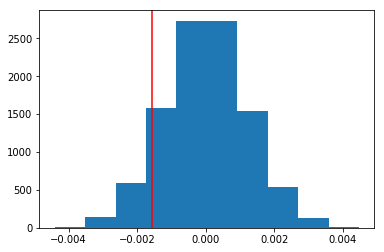

In [44]:
plt.hist(p_diffs)
plt.axvline(obs_value, color = "r")

The proportion of the `p_diffs` which are greater than the actual difference observed in our dataset is:

In [29]:
p_value = (p_diffs > obs_value).mean()
p_value

0.9046

__*Here we have computed the statistical probability of getting a result such as the observed value (obs_value) while being under the null hypothesis. We have previously set the significance level of this hypothesis test to $\alpha = 0.05$. Therefore, any p-value above 0.05 (5%) would not suggest the rejection of the null hypothesis.*__

**_Since our p-value is 0.9064 (~90%), this suggests that, with extremely high likelihood, the behaviour of our tested value (the difference in conversion ratios between old and new pages) is as per the null hypothesis, meaning that the old page conversion ratios are better (or at least equal) to those of the new page._**

We may also have used a built-in library to achieve similar results. Though using the built-in library might be easier to code, the above portions are a walkthrough of the ideas that are critical to thinking correctly about statistical significance. 

_Below is a run-down of the same hypothesis test using the z-test from Python statistical model library:_

In [30]:
import statsmodels.api as sm

convert_old = len(df2.query("landing_page == 'old_page'").query("converted == 1"))
convert_new = len(df2.query("landing_page == 'new_page'").query("converted == 1"))
n_old = len(df2.query("landing_page == 'old_page'"))
n_new = len(df2.query("landing_page == 'new_page'"))

In [31]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative= 'larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

__*The z-score and p-value agree fully to the previous manual results. More precisely, we can see only a very slight difference in p-values between the two tests (0.906 vs. 0.905). The results show that, indeed, the old page generates better conversion rates than the new one.*__

__*The z-score is representing how many standard deviations  our observed value (differences between proportions) is from the mean of the distribution (which is sampled from the null hypothesis). A z-score of -1.31 means that our observed value is $1.31\sigma$ lower than the mean of the sampling distribution. Looking for the area under the bell curve to the right of the z-score value, for a graph of the sampling distribution, it means that our observed difference was lower in value than 90.4% of the random sampling differences.*__

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will examine and re-evaluate the result acheived in the previous A/B test by performing logistic regression.

__*We are interested in determining whether individuals will convert or not, depending on the type of landing page seen.*__


__*Therefore, we have a response variable characterized by categorical "response - no response" values. Since each row is either a conversion or no conversion, our regression approach indicates using a logistic regression in order to get the best prediction model possible.*__

The goal here is to use `statsmodels` to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives.  

First, we need to create a column for the intercept, and also create a dummy variable column for which page each user received.
An `intercept` column will be added, as well as an `ab_page` column, which represents 1 when an individual receives the **treatment** and 0 for **control**.

In [32]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [33]:
df2['intercept'] = 1

In [34]:
df2 = df2.join(pd.get_dummies(df['landing_page']))
df2 = df2.drop('old_page', axis = 1)
df2 = df2.rename({'new_page' : 'ab_page'}, axis = 'columns')

We use **statsmodels** to fit our regression model using the `intercept` and `ab_page` columns to predict whether or not an individual converts.

In [35]:
model = sm.Logit(endog = df2['converted'], exog = df2[['intercept', 'ab_page']])
model_fit = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


The summary of the logistic model is provided below:

In [36]:
print(model_fit.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 10 Nov 2018   Pseudo R-squ.:               8.077e-06
Time:                        22:55:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007


__*As we can see from the summary of our logistic regression model, the predictor variable (relating to the outcome of having recieved a new or old page version) is not shown to be significantly contributing to predicting conversion rate in any way, neither statistically nor practically. That is due to the high p-value obtained: 0.19. Low statistical significance of our predictor can also be demonstrated from the inclusion of the null-hypothesis value of 0 in the 95% confidence interval.*__

__*For reference, we might be asking ourselves why this p-value differs to the one obtained in our A/B hypothesis testing. This is due to the different hypotheses chosen for the two tests. In the logistic regression case, our hypothesis for the predictor variable were chosen as :*__

$$ H_0: \beta_{ab\_test} = 0 $$
$$ H_1: \beta_{ab\_test} \neq 0 $$

*Generally, for a regression test, we would want to have as many as possible of linearly independent predictors related to our response variable* (`converted`)*, as this will increase the chances for the model to correctly determine which individuals are more likely to convert, and we will be able to find out which predictors are significant in increasing conversion.*

*However, for our data, adding some of our remaining variables will actually decrease the accuracy of our model and introduce multicollinearity errors. This is because the variables* `group`, `landing_page` *and* `ab_page` *are strongly collinear, as they represent mainly the same thing: whether the individual has experiment conditions from control type or from treatment type.*

*Moreover, adding the* `user_id` *to our model is likely irrelevant, as all of our users have only one dataset entry each. Timestamp of conversion could be interesting to consider, if we would transform it into a categorical variable representing e.g. the month during which conversion was made.*

Now along with testing if the conversion rate changes for different pages, we also add an effect based on which country a user lives in (either US, UK or Canada), due to the making available of another dataset: **countries.csv**, containing the country where the unique user (_determined by the_ `user_id`_)_ resides.

In [37]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [38]:
df_new = df_new.join(pd.get_dummies(df_new['country']))

In [39]:
model = sm.Logit(endog = df_new['converted'], exog = df_new[['intercept', 'ab_page', 'CA', 'UK']])
model_fit = model.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [40]:
print(model_fit.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 10 Nov 2018   Pseudo R-squ.:               2.323e-05
Time:                        22:56:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.1

___By adding the catergorical predictor_ `country`__, ___we are trying to discover whether it is statistically significant that our users come from the US, UK or Canada.___

___Considering the large p-values of___ **0.13 and 0.457**,  ***respectively, for the predictors of having users from CA and UK, we can understand that, regardless on whether our users come from the baseline category (US) or any of the other possible countries, the conversion rate for these users will not increase much.***

For the past two models, we have only looked at the influence of the individual factors of `country` and `ab_page` on conversion.

Now, we would also like to look at a possible interaction between `ab_page` and `country` to see if there are significant effects on conversion.

In [41]:
df_new['CA_page_ab'] = df_new['CA'] * df_new['ab_page']
df_new['UK_page_ab'] = df_new['UK'] * df_new['ab_page']
df_new['US_page_ab'] = df_new['US'] * df_new['ab_page']

In [42]:
model = sm.Logit(endog = df_new['converted'], exog = df_new[['intercept', 'ab_page', 'UK', 'CA', 'UK_page_ab', 'CA_page_ab']])
model_fit = model.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [43]:
print(model_fit.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 10 Nov 2018   Pseudo R-squ.:               3.482e-05
Time:                        22:56:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK            -0.0057      0.019     -0.306      0.7

**_As before, the p-values for the predictors in this model do not show any statistical significance. Therefore, it is unlikely that an interaction between the landing page version and the user country will influence our conversion rates._**

<a id='conclusions'></a>
## Conclusions

**_As an overall conclusion, we have been able to demonstrate statistically, using either of: probabilistic reasoning, hypothesis testing, and logistic regression, that:_** 
* **_receiving the newer version of the landing page will not increase user conversion rate for the e-commerce company;_**
* **_demographic distribution of users also is statistically unlikely to influence user conversion rate for the e-commerce company;_**

**_Overall, we have noticed neither statistical nor practical significance in the company launching the new page version._**